In [1]:
import mlatom as ml
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# prepare H2 geometries with bond lengths ranging from 0.5 to 5.0 Å
xyz = np.zeros((451, 2, 3))
xyz[:, 1, 2] = np.arange(0.5, 5.01, 0.01)
z = np.ones((451, 2)).astype(int)
molDB = ml.molecular_database.from_numpy(coordinates=xyz, species=z)

In [3]:
# calculate HF energies
hf = ml.models.methods(method='HF/STO-3G', program='PySCF')
hf.predict(molecular_database=molDB, calculate_energy=True)
molDB.add_scalar_properties(molDB.get_properties('energy'), 'HF_energy') # save HF energy with a new name

In [4]:
# calculate CISD energies
cisd = ml.models.methods(method='CISD/cc-pVDZ', program='PySCF')
cisd.predict(molecular_database=molDB, calculate_energy=True)
molDB.add_scalar_properties(molDB.get_properties('energy'), 'CISD_energy')

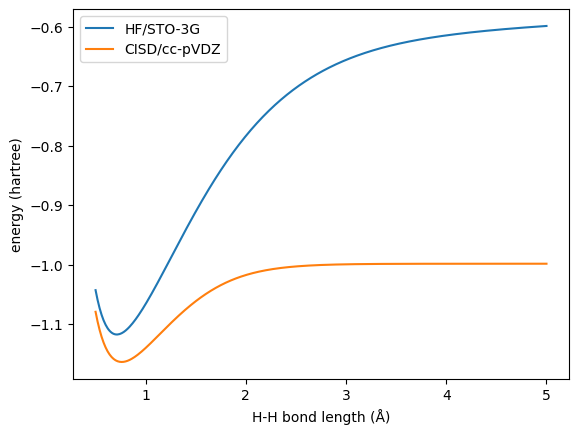

In [18]:
# plot the energies
plt.plot(xyz[:, 1, 2], molDB.get_properties('HF_energy'), label='HF/STO-3G')
plt.plot(xyz[:, 1, 2], molDB.get_properties('CISD_energy'), label='CISD/cc-pVDZ')
plt.legend()
plt.xlabel('H-H bond length (Å)')
plt.ylabel('energy (hartree)')
plt.show()

In [6]:
# train ANI model with HF energies
! rm ANI-HF.pt &> /dev/null
ani = ml.models.ani(model_file='ANI-HF.pt', verbose=False)
ani.train(molecular_database=molDB, property_to_learn='HF_energy')
# predict with trained ANI model
ani.predict(molecular_database=molDB, property_to_predict='ANI_HF_energy')

In [7]:
# show the model structure
ani.model


Sequential(
  (0): AEVComputer()
  (1): ANIModel(
    (H): Sequential(
      (0): Linear(in_features=48, out_features=160, bias=True)
      (1): CELU(alpha=0.1)
      (2): Linear(in_features=160, out_features=128, bias=True)
      (3): CELU(alpha=0.1)
      (4): Linear(in_features=128, out_features=96, bias=True)
      (5): CELU(alpha=0.1)
      (6): Linear(in_features=96, out_features=1, bias=True)
    )
  )
)

In [8]:
# fix some of the layers
! cp ANI-HF.pt ANI-HF-TL.pt
ani = ml.models.ani(model_file='ANI-HF-TL.pt', verbose=False)
ani.fix_layers([[0, 6]])
# transfer leaning with every 40th of the data  
step = 40
val = molDB[::step][::10]
sub = ml.molecular_database([mol for mol in molDB[::step] if mol not in val])
ani.energy_shifter.self_energies = None # let the model recalculate the self atomic energies
ani.train(molecular_database=sub, validation_molecular_database=val, property_to_learn='CISD_energy', hyperparameters={'learning_rate': 0.0001}, reset_optimizer=True)
# predict with TL model
ani.predict(molecular_database=molDB, property_to_predict='ANI_TL_energy')

In [9]:
# train ANI model with CISD energies directly
! rm ANI_CISD.pt &> /dev/null
ani_cisd = ml.models.ani(model_file='ANI_CISD.pt', verbose=False)
ani_cisd.train(molecular_database=sub, validation_molecular_database=val, property_to_learn='CISD_energy')
# predict with trained ANI model
ani_cisd.predict(molecular_database=molDB, property_to_predict='ANI_CISD_energy')

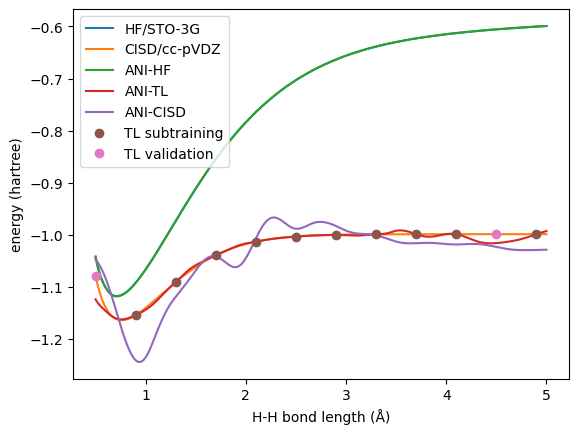

In [17]:
# plot the energies
plt.plot(xyz[:, 1, 2], molDB.get_properties('HF_energy'), label='HF/STO-3G')
plt.plot(xyz[:, 1, 2], molDB.get_properties('CISD_energy'), label='CISD/cc-pVDZ')
plt.plot(xyz[:, 1, 2], molDB.get_properties('ANI_HF_energy'), label='ANI-HF')
plt.plot(xyz[:, 1, 2], molDB.get_properties('ANI_TL_energy'), label='ANI-TL')
plt.plot(xyz[:, 1, 2], molDB.get_properties('ANI_CISD_energy'), label='ANI-CISD')
plt.plot(sub.xyz_coordinates[:, 1, 2], sub.get_properties('CISD_energy'), 'o', label='TL subtraining')
plt.plot(val.xyz_coordinates[:, 1, 2], val.get_properties('CISD_energy'), 'o', label='TL validation')
plt.legend()
plt.xlabel('H-H bond length (Å)')
plt.ylabel('energy (hartree)')
plt.show()